### Imports

In [2]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
from torch.autograd import Variable

### Dataset

In [3]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

# Load dataset
dataset = datasets.ImageFolder("./dataset/train/", transform=transform)
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,)

### Generator

In [4]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, out_channels=3, kernel_size=4, stride=2, padding=1)
        
        )
        self.out= nn.Tanh()

        
    def forward(self, x):
        return self.out(self.generator(x))

### Discriminator 

In [5]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True))
            
        #self.output = nn.Conv2d(in_channels=1024, out_channels=3, kernel_size=4, stride=1, padding=0)
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.output(self.discriminator(x))

### DCGAN

In [8]:
class DCGAN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.G = Generator()
        self.D = Discriminator()

        self.loss = nn.BCELoss()

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.batch_size = 64

        self.D.cuda()
        self.G.cuda()
        self.loss = nn.BCELoss().cuda()
        
        
    def train(self, train_loader):
        for epoch in range(50):
            #for images, _ in train_loader:
            for i, (images, _) in enumerate(train_loader):
                if i == train_loader.dataset.__len__() // self.batch_size:
                    break

                z = torch.rand((self.batch_size, 100, 1, 1))
                real_labels = torch.ones(self.batch_size)
                fake_labels = torch.zeros(self.batch_size)

                
                images, z = Variable(images).cuda(), Variable(z).cuda()
                real_labels, fake_labels = Variable(real_labels).cuda(), Variable(fake_labels).cuda()

                outputs = self.D(images)
                d_loss_real = self.loss(outputs, real_labels.view(-1,1,1,1)) # ERROR
                real_score = outputs

                # Compute BCE Loss using fake images
                z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
                
                fake_images = self.G(z)
                outputs = self.D(fake_images)
                d_loss_fake = self.loss(outputs, fake_labels.view(-1,1,1,1))
                fake_score = outputs

                # Optimize discriminator
                d_loss = d_loss_real + d_loss_fake
                self.D.zero_grad()
                d_loss.backward()
                self.d_optimizer.step()

                # Train generator
                # Compute loss with fake images
                
                z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
            
                fake_images = self.G(z)
                outputs = self.D(fake_images)
                g_loss = self.loss(outputs, real_labels.view(-1,1,1,1))

                # Optimize generator
                self.D.zero_grad()
                self.G.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()
                
    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu()[:number_of_images]
        generated_images = []
        for sample in samples:
            generated_images.append(sample.reshape(3, 32, 32))
        return generated_images

### Train Model

In [9]:
model = DCGAN()
model.load_state_dict(torch.load("model_300.th"))
model.train(train_loader)
z = Variable(torch.randn(1, 100, 1, 1)).cuda()
images = model.generate_img(z,1)



### Visualize Results

In [10]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

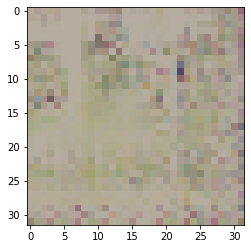

In [12]:
imshow(images[0])

In [ ]:
torch.save(model.state_dict(), "model_300.th")

### WGAN

In [18]:
class WGAN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.G = Generator()
        self.D = Discriminator()

        self.d_optimizer = torch.optim.RMSprop(self.D.parameters(), lr=0.00005)
        self.g_optimizer = torch.optim.RMSprop(self.G.parameters(), lr=0.00005)

        self.batch_size = 64

        self.D.cuda()
        self.G.cuda()
        
        
    def train(self, train_loader):
        self.data=self.get_infinite_batches(train_loader)
        one = Variable(torch.FloatTensor([1]))
        mone = one * -1
        one = one.cuda()
        mone = mone.cuda()
        for g_iter in range(50):
            for p in self.D.parameters():
                p.requires_grad = True
                
            for d_iter in range(20):
                self.D.zero_grad()

                for p in self.D.parameters():
                    p.data.clamp_(-10, 10)

                images = self.data.__next__()

                if (images.size()[0] != self.batch_size):
                    continue

                z = torch.rand((self.batch_size, 100, 1, 1))

                
                images, z = Variable(images.cuda()), Variable(z.cuda())
                

                # Train discriminator
                d_loss_real = self.D(images)
                d_loss_real = d_loss_real.mean(0).view(1)
                d_loss_real.backward(one)

                # Train with fake images
                z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
                fake_images = self.G(z)
                d_loss_fake = self.D(fake_images)
                d_loss_fake = d_loss_fake.mean(0).view(1)
                d_loss_fake.backward(mone)

                d_loss = d_loss_fake - d_loss_real
                Wasserstein_D = d_loss_real - d_loss_fake
                self.d_optimizer.step()
                
            # Generator update
            for p in self.D.parameters():
                p.requires_grad = False  # to avoid computation

            self.G.zero_grad()

            # Train generator
            z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
            fake_images = self.G(z)
            g_loss = self.D(fake_images)
            g_loss = g_loss.mean().mean(0).view(1)
            g_loss.backward(one)
            g_cost = -g_loss
            self.g_optimizer.step()

    def get_infinite_batches(self, data_loader):
        while True:
            for i, (images, _) in enumerate(data_loader):
                yield images
    
    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu()[:number_of_images]
        generated_images = []
        for sample in samples:
            generated_images.append(sample.reshape(3, 32, 32))
        return generated_images

In [19]:
model = WGAN()
#model.load_state_dict(torch.load("model_300.th"))
model.train(train_loader)
z = Variable(torch.randn(1, 100, 1, 1)).cuda()
images = model.generate_img(z,1)
imshow(images[0])

NameError: name 'imshow' is not defined